In [1]:
# ! pip install ipynb

In [2]:
import import_ipynb
import numpy as np
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.theta import ThetaModel
from scipy.optimize import fsolve
from scipy.special import rel_entr, kl_div
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [3]:
from ipynb.fs.full.DFA_func import (plot_density_forecast, aggregating_algorithm,
                                    get_optim_m, plot_losses, get_all_predictions, plot_total_losses)

In [4]:
sunspot_ts = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv')
sunspot_ts.index = sunspot_ts['time'].values
sunspot_ts.drop(['Unnamed: 0', 'time'], axis=1, inplace=True)
sunspot_ts.rename({'value': 'sunspot.year'}, axis=1, inplace=True)

In [5]:
wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/monthly-wage.csv', sep=';', index_col= 0, parse_dates=True)
wage_ts = wage.astype(int)

**Пример использования**

In [6]:
base_alg_list = [(Holt, {}, {}),
                 (SimpleExpSmoothing, {}, {}),
                 (ExponentialSmoothing, {}, {}),
                 (ExponentialSmoothing, {"trend": "additive"}, {}),
                 (ARIMA, {'order': (1, 2, 0)}, {})]
best_m, best_loss, n_bins = get_optim_m(sunspot_ts, base_alg_list,
                                        bins=10, omega_mode="mean")

print(f"m={best_m} - {best_loss}, n_bins={n_bins}")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

m=3.5 - 0.6574654285871606, n_bins=12


  0%|          | 0/299 [00:00<?, ?it/s]

Theoretical bound met


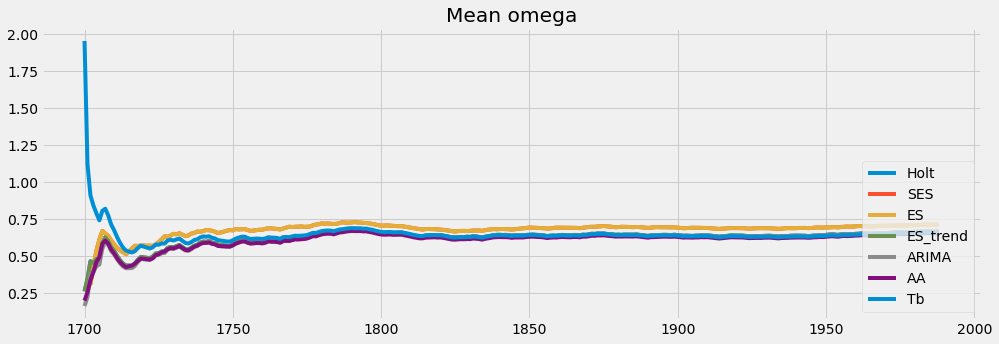

In [7]:
fig, ax = plt.subplots(1, figsize=(15,5))

plot_losses(sunspot_ts, 10, base_alg_list,
            omega_mode="mean", bins=10, best_m=best_m, ax=ax,
            title="Mean omega", legend=['Holt', 'SES', 'ES', 'ES_trend', 'ARIMA', 'AA', 'Tb'])

## Предобработка данных

In [8]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_train.Date = pd.to_datetime(df_train.Date, dayfirst = True)
df_train.set_index(['Date'], inplace=True)
df_test.Date = pd.to_datetime(df_test.Date, dayfirst = True)
df_test.set_index(['Date'], inplace=True)

df_train.head(3)

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-01-01,1,1,NaN,22,163.78,NaN
2015-01-02,1,1,NaN,41,163.78,NaN
2015-01-03,1,1,NaN,35,163.78,NaN


In [9]:
df_train.Demand.isna().sum()

0

In [10]:
ts_dict = {}

for store_id in df_train.Store_id.unique():
    for sku_id in df_train.SKU_id.unique():
        ts = df_train[(df_train.Store_id == store_id) & (df_train.SKU_id == sku_id)]["Demand"]
        if not ts.empty:
            ts_dict[f"sku{sku_id}_store{store_id}"] = ts

Каждый элемент словаря содержит pandas.Series

Всего 206 уникальных временных рядов, длиной 508 тайм стемпов.

In [11]:
len(ts_dict)

206

## Подбор базовых алгоритмов

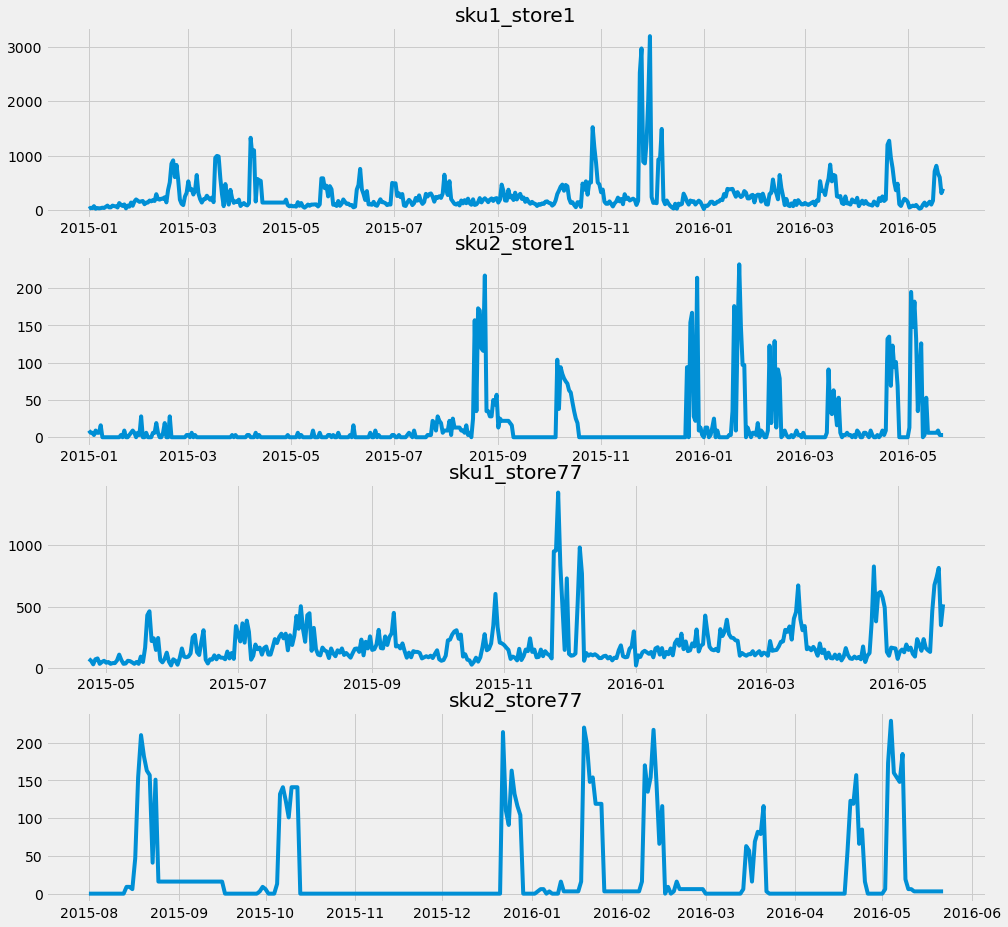

In [12]:
fig, ax = plt.subplots(4, figsize=(15,15))

ax[0].plot(ts_dict["sku1_store1"])
ax[0].set_title("sku1_store1")
ax[1].plot(ts_dict["sku2_store1"])
ax[1].set_title("sku2_store1")
ax[2].plot(ts_dict["sku1_store77"])
ax[2].set_title("sku1_store77")
ax[3].plot(ts_dict["sku2_store77"])
ax[3].set_title("sku2_store77");

Данные надо будет разбить на трейн и тест или кросс-валидации всё смотреть.

Всего будет n базовых алгоритмов: SES, 3 ES (trend, seasonality etc.), ARIMA


In [13]:
base_alg_list = [
    (ExponentialSmoothing, {}, {"smoothing_level": 0.95}),
#     (ExponentialSmoothing, {}, {"smoothing_level": 0.9}),
    (ExponentialSmoothing, {}, {"smoothing_level": 0.8}),
#     (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.95, "smoothing_seasonal": 0.9}),
#     (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.95, "smoothing_seasonal": 0.6}),
#     (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.9, "smoothing_seasonal": 0.9}),
#     (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.9, "smoothing_seasonal": 0.6}),
    (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.8, "smoothing_seasonal": 0.9}),
    (ExponentialSmoothing, {"seasonal": "add", "seasonal_periods": 7}, {"smoothing_level": 0.8, "smoothing_seasonal": 0.6}),
    (ARIMA, {'order': (1, 2, 0)}, {})
                 ]


### Построение агрегирующего алгоритма

Здесь можно нарисовать графики с различными m и omega_mode. Также попробовать разные p и дли них изобразить графики.

In [17]:
best_m, best_loss, n_bins = get_optim_m(ts_dict["sku1_store1"], base_alg_list,
                                        bins=10, omega_mode="basic")

print(f"m={best_m} - {best_loss}, n_bins={n_bins}")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

  0%|          | 0/508 [00:00<?, ?it/s]

m=3.5 - 0.26788207043739487, n_bins=10


  0%|          | 0/518 [00:00<?, ?it/s]

Theoretical bound met


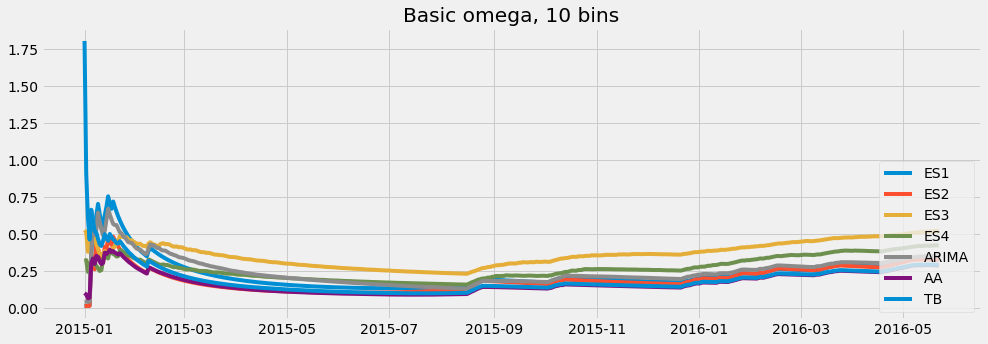

In [21]:
fig, ax = plt.subplots(1, figsize=(15,5))

plot_losses(ts_dict["sku2_store50"], 10, base_alg_list,
            omega_mode="basic", bins=10, best_m=best_m, ax=ax,
            title="Basic omega, 10 bins", legend=['ES1', 'ES2', 'ES3', 'ES4',
                                        'ARIMA', 'AA', 'TB'])

### Анализ результатов (AA vs Base Algorithms)

In [22]:
pred_dict, losses_dict = get_all_predictions(ts_dict, 5, base_alg_list, omega_mode="basic", best_m=best_m, bins=10)

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/513 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/337 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [23]:
losses_508_dict = {}
i = 0
for sku, losses in losses_dict.items():
    if losses['alg1'].size == 508:
        losses_508_dict[sku] = losses

alg1: 0.2499708396082771
alg2: 0.247834607857382
alg3: 0.4234819301207214
alg4: 0.32558825346886655
alg5: 0.29157126618437545
AA: 0.243392508918789


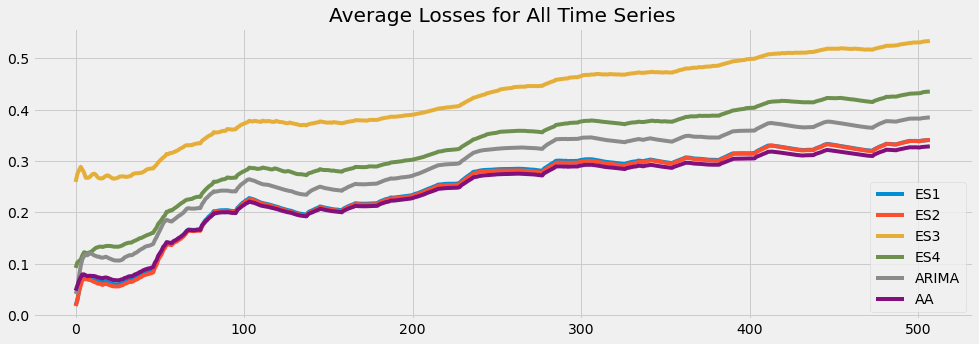

In [24]:
fig, ax = plt.subplots(1, figsize=(15,5))

plot_total_losses(losses_508_dict, ax, "Average Losses for All Time Series",
                  ['ES1', 'ES2', 'ES3', 'ES4', 'ARIMA', 'AA'])

###  Сравнение с другими методами композиции алгоритмов (Adaptive Selection and Adaptive Combination)